In [1]:
import pandas as pd
import numpy as np
import os, pickle
import torch
import torch.nn as nn
from tqdm import tqdm

from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from novelddi.evaluate.metrics import get_metrics_binary, get_metrics

from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer, LlamaModel, LlamaTokenizer

path_base = '/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/'

In [2]:
description_df = pd.read_csv(os.path.join(path_base, 'polypharmacy_new/DrugBank/drugbank_ddi_directed_final_cleaned.tsv'))

In [3]:
# run = 'wandering-cosmos-95'
# epoch = 6

runs_no_para = ['autumn-water-105', 'eternal-cherry-106', 'curious-cosmos-104']

runs = ['restful-fire-101', 'glorious-deluge-103', 'light-silence-102']
epoch = 6

In [12]:
desc = ['Analgesic, increase',
           'Bioavailability, increase',
           'Thrombocytopenia and bleeding increase',
            'Gastrointestinal bleeding, increase',
            'Gastrointestinal ulceration and irritation, increase',
            'Hypertension, increase',
            'Hypertension and tardive dyskinesia, increase',
            'Hypotension and electrolyte disturbance, increase',
            'Methemoglobinemia, increase',
            'Nephrotoxicity, increase',
            'Neuroexcitatory, increase',
            'Renal failure, hypotension, increase',
            'Sedation, decrease',
            'Serum level of the active metabolites and efficacy, decrease',
            'Serum level of the active metabolites, increase',
            'Thrombocytopenia, increase'
           ]
new_desc = []
for de in desc:
    de = de.replace(", increase", " \u2191")
    de = de.replace(", decrease", " \u2193")
    new_desc.append(de)

# Naive baseline

In [4]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy import stats
from tqdm import tqdm

device = 'cuda'

lm_model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
tokenizer =  BertTokenizer.from_pretrained(lm_model)

model = BertModel.from_pretrained(lm_model).to(device)

In [5]:
def get_label_embeddings(split):
    
    df = pd.read_csv(f'../LM_decoder/paraphrased_dataset/{split}_df.csv') 
    
    label_descriptions = np.unique(df['label_descriptions'].values)
    labels = np.unique(df['labels'])

    example_encoding = tokenizer.batch_encode_plus(
    label_descriptions.tolist(),
    padding=True,
    return_tensors='pt',
    add_special_tokens=True)
    
    print('now here')
    
    example_input_ids = example_encoding['input_ids'].to(device)
    example_attention_mask = example_encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
        example_sentence_embedding = example_outputs.last_hidden_state[:,0,:].cpu().numpy()
    
    return example_sentence_embedding, label_descriptions, labels, df

In [6]:
train_embeddings, label_train_descriptions, labels_train, train_df = get_label_embeddings('train')
eval_embeddings, label_eval_descriptions, labels_eval, eval_df = get_label_embeddings('eval')
similarity_score = cosine_similarity(train_embeddings, eval_embeddings)

now here
now here


In [7]:
train_df_pos = train_df[train_df['pos_neg'] == 1]
num_pos = train_df_pos.shape[0]


label_mapping = {}

for i in range(label_eval_descriptions.shape[0]):
    sims = similarity_score[:,i]
    top_k = sims.argsort()[::-1][:3]
    
    top_train_label_desc = [label_train_descriptions[j] for j in top_k]
    train_df_subset = train_df_pos[train_df_pos['label_descriptions'].isin(top_train_label_desc)]
    
    train_df_rev = train_df_subset.copy()
    train_df_rev['head'], train_df_rev['tail'] = train_df_subset['tail'], train_df_subset['head']
    
    train_df_new = pd.concat([train_df_subset, train_df_rev], ignore_index=True)
    
    drug_scores = {}

    for drug in tqdm(train_df_new['head'].unique()):
        score = train_df_new[train_df_new['head'] == drug]['pos_neg'].shape[0]
        drug_scores[drug] = score/num_pos 
    
    label_mapping[label_eval_descriptions[i]] = drug_scores

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1833.59it/s]


In [8]:
label_naive_scores = []

for i in tqdm(range(eval_df.shape[0])):
    
    drug_1 = eval_df.loc[eval_df.index[i], 'head']
    drug_2 = eval_df.loc[eval_df.index[i], 'tail']
    label = eval_df.loc[eval_df.index[i], 'label_descriptions']
    
    label_idx = eval_df.loc[eval_df.index[i], 'labels']
    
    drug_scores = label_mapping[label]
    
    try:
        drug_score_1 = drug_scores[drug_1]
    except:
        drug_score_1 = 0
    
    try:
        drug_score_2 = drug_scores[drug_2]
    except:
        drug_score_2 = 0
    
    label_naive_scores.append((drug_score_1 + drug_score_2)/2)
    
#     label_naive_scores[label_idx].append((drug_score_1 + drug_score_2)/2)
#     label_pos_neg[label_idx].append( eval_df.loc[eval_df.index[i], 'pos_neg'])
    

100%|█████████████████████████████████████████████████████████████████████████| 266208/266208 [00:13<00:00, 19886.61it/s]


In [9]:
labels = eval_df['labels'].values
unique_labels = np.unique(labels)
pos_neg = eval_df['pos_neg'].values

test_metrics_naive, _ = get_metrics(
    np.array(label_naive_scores), 
    pos_neg, 
    labels, 
    k=50, 
    task='multiclass', 
    average=None, 
    logger=None, 
    verbose=False, 
)

/home/vau974/protein_new/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/vau974/protein_new/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [10]:
np.save('./naive_metrics.npy', test_metrics_naive)

#metrics = get_metrics_binary(np.array(label_naive_scores), pos_neg, k=50)

## Our model label stratified perfromance: Fig 1

In [ ]:
eval_df_normal = pd.read_csv(f'../LM_decoder/dataset/eval_df.csv')
labels = eval_df_normal['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]

In [ ]:
eval_df = pd.read_csv(f'../LM_decoder/paraphrased_dataset_new/eval_df.csv')

In [ ]:
def sig(x):
    return 1/(1 + np.exp(-x))

def get_auprc(run, epoch, eval_df):
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    all_test_metrics = []
    base = '/n/data1/hms/dbmi/zitnik/lab/users/vau974/ddi/NovelDDI/LM_decoder/'
    for i in tqdm(range(10)):
        eval_preds = np.load(base + f'{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        test_metrics, _ = get_metrics(
        sig(eval_preds), 
        pos_neg, 
        labels, 
        k=50, 
        task='multiclass', 
        average=None, 
        logger=None, 
        verbose=False)
        unique_labels_desc = [label_to_desc[l] for l in unique_labels]
        all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

metrics_repeat = []
for run in runs:
    metrics, desc = get_auprc(run, epoch, eval_df)
    metrics_repeat.append(metrics)

In [ ]:
metrics_repeat = np.array(metrics_repeat)
metrics_mn = metrics_repeat.mean(axis=0)
metrics_std = metrics_repeat.std(axis=0)

In [ ]:
def get_auprc_no_para(run, epoch, eval_df):
    
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    
    all_test_metrics = []
    base = '/n/data1/hms/dbmi/zitnik/lab/users/vau974/ddi/NovelDDI/LM_decoder/'
    
    eval_preds = np.load(base + f'{run}/eval_raw_scores_{epoch}.npy')
    test_metrics, _ = get_metrics(
    sig(eval_preds), 
    pos_neg, 
    labels, 
    k=50, 
    task='multiclass', 
    average=None, 
    logger=None, 
    verbose=False)
    unique_labels_desc = [label_to_desc[l] for l in unique_labels]
    all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

normal_metrics_repeat = []
for run in runs_no_para:
    metrics, normal_desc = get_auprc_no_para(run, 5, eval_df_normal)
    normal_metrics_repeat.append(metrics)

In [ ]:
normal_metrics_repeat = np.array(normal_metrics_repeat)
normal_metrics_mn = normal_metrics_repeat.mean(axis=0)
normal_metrics_std = normal_metrics_repeat.std(axis=0)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=300)

df_1 = pd.DataFrame({'AUPRC': np.concatenate([normal_metrics_repeat.reshape(48), metrics_repeat[:,0,:].reshape(48)]),
                     'Drug-Drug interaction class': np.concatenate([new_desc]*6),
                    'label': ['Trained on original descriptions']*48 + ['Trained on augmented descriptions']*48})

df_1.to_csv('./plot_5a.csv')

result = df_1.groupby(["Drug-Drug interaction class"])['AUPRC'].aggregate(np.mean).reset_index().sort_values('AUPRC')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
g = sns.barplot(
    data=df_1,
    errorbar="sd",
    x="AUPRC", y="Drug-Drug interaction class", hue="label", palette="Set1", order=result['Drug-Drug interaction class'])
sns.despine()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

plt.savefig('performance_augmented_vs_normal_rep_sns.pdf')

In [ ]:
# def sort_four(arr1, arr2, arr3, arr4):
#     arg_sort = arr1.argsort()
#     return arr1[arg_sort], np.array(arr2)[arg_sort], np.array(arr3)[arg_sort], np.array(arr4)[arg_sort]

# normal_metrics_sort, metrics_mn_sort, metrics_std_sort, desc_sort  = sort_four(normal_metrics, metrics_mn[0,:], metrics_std[0,:], desc)

In [ ]:
# def sort_by_first_array(first_array, *additional_arrays):
#     sorted_indices = np.argsort(first_array)
    
#     sorted_arrays = [first_array[sorted_indices]]
    
#     for array in additional_arrays:
#         sorted_arrays.append(np.array(array)[sorted_indices])
    
#     return tuple(sorted_arrays)

# normal_metrics_mn_sort, normal_metrics_std_sort, metrics_mn_sort, metrics_std_sort, desc_sort  = sort_by_first_array(normal_metrics_mn,
#                                                                                                                     normal_metrics_std,
#                                                                                                                     metrics_mn[0,:], 
#                                                                                                                     metrics_std[0,:], 
#                                                                                                                     desc)

In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 9})

# fig, ax = plt.subplots(figsize=(8, 8))

# width = 0.4

# ind = np.arange(len(desc))

# ax.barh(ind, normal_metrics_mn_sort, width, color='red', xerr=normal_metrics_std_sort, label='Trained on original descriptions')
# ax.barh(ind + width, metrics_mn_sort, width, color='green', xerr=metrics_std_sort, label='Trained on augmented descriptions')

# ax.set(yticks=ind + width, yticklabels=desc_sort)

# ax.legend()
# #ax.legend(bbox_to_anchor=(1.4, 0.98))
# ax.set_xlabel('AUPRC')
# ax.set_ylabel('Evaluation DDI class')
# ax.set_title('Effect of text augmentation on AUPRC on evaluation set', fontsize = 9)

# # ax.axvline(0.376)
# #plt.tight_layout()
# #plt.savefig(f'performance_augmented_vs_normal_rep.pdf')

In [ ]:
# plt.rcParams.update({'font.size': 9})

# fig, ax = plt.subplots(figsize=(10, 10), dpi=600)

# width = 0.4
# ind = np.arange(len(desc_sort))

# ax.barh(ind, normal_metrics_mn_sort, width, color='#1f77b4', 
#         xerr=normal_metrics_std_sort, 
#         label='Trained on original descriptions',
#         edgecolor = "black")
# ax.barh(ind + width, metrics_mn_sort, width, color='#ff7f0e', 
#         xerr=metrics_std_sort, 
#         label='Trained on augmented descriptions', 
#         edgecolor = "black")

# ax.set(yticks=ind + width / 2, yticklabels=desc_sort)
# ax.legend(frameon=False, loc='best')
# ax.set_xlabel('AUPRC', fontweight='bold')
# ax.set_ylabel('Drug-Drug interaction class', fontweight='bold')
# #ax.set_title('Effect of text augmentation on AUPRC on evaluation set', fontsize=10)

# ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
# ax.set_axisbelow(True)

# plt.tight_layout()
# plt.savefig('performance_augmented_vs_normal_rep.pdf')
# plt.show()

## Our model label stratified perfromance: Fig 2

In [14]:
eval_df = pd.read_csv(f'../LM_decoder/paraphrased_dataset_new/eval_df.csv')
labels = eval_df['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]

In [15]:
def sig(x):
    return 1/(1 + np.exp(-x))

def sort_three(arr1, arr2, arr3, col=0):
    arg_sort = arr1[:,col].argsort()
    return arr1[arg_sort,:], np.array(arr2)[arg_sort], np.array(arr3)[arg_sort,:]

def sort_four(arr1, arr2, arr3, arr4, col=0):
    arg_sort = arr1[:,col].argsort()
    return arr1[arg_sort,:], np.array(arr2)[arg_sort], np.array(arr3)[arg_sort,:], np.array(arr4)[arg_sort,:]

def get_auprc(run, epoch, eval_df):
    
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    
    all_test_metrics = []
    base = '/n/data1/hms/dbmi/zitnik/lab/users/vau974/ddi/NovelDDI/LM_decoder/'
    
    for i in tqdm(range(10)):
        eval_preds = np.load(base + f'{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        test_metrics, _ = get_metrics(
        sig(eval_preds), 
        pos_neg, 
        labels, 
        k=50, 
        task='multiclass', 
        average=None, 
        logger=None, 
        verbose=False)
        unique_labels_desc = [label_to_desc[l] for l in unique_labels]
        all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

def plot_stratified(runs, epoch, eval_df, test_metrics_naive=None):
    
    all_auprc_repeat = []
    
    for run in runs:
        all_auprc, unique_labels_desc = get_auprc(run, epoch, eval_df)
        all_auprc_repeat.append(all_auprc)
        
    all_auprc_repeat = np.array(all_auprc_repeat)
    
    return all_auprc_repeat
    
#     if test_metrics_naive is not None:
#         num_categories = 5
#     else:
#         num_categories = 4
    
#     all_auprc_mean_grouped = [0]*num_categories
#     all_auprc_std_grouped = [0]*num_categories

#     def stratify_by_paraphrasing(start, stop):
#         elems = []
#         for i in range(len(runs)):
#             for j in range(start, stop):
#                 elems.append(all_auprc_repeat[i,j])
#         return np.stack(elems)
    
#     desc_0 = stratify_by_paraphrasing(0,1)
#     desc_1 = stratify_by_paraphrasing(1,4)
#     desc_2 = stratify_by_paraphrasing(4,7)
#     desc_3 = stratify_by_paraphrasing(7,10)
    
#     all_auprc_mean_grouped[0] = np.mean(desc_0, axis=0)
#     all_auprc_mean_grouped[1] = np.mean(desc_1, axis=0)
#     all_auprc_mean_grouped[2] = np.mean(desc_2, axis=0)
#     all_auprc_mean_grouped[3] = np.mean(desc_3, axis=0)
    
#     all_auprc_std_grouped[0] = np.std(desc_0, axis=0)
#     all_auprc_std_grouped[1] = np.std(desc_1, axis=0)
#     all_auprc_std_grouped[2] = np.std(desc_2, axis=0)
#     all_auprc_std_grouped[3] = np.std(desc_3, axis=0)
    
#     if test_metrics_naive is not None:
#         all_auprc_mean_grouped[4] = np.array(test_metrics_naive)
#         all_auprc_std_grouped[4] = np.array([0]*16)
    
#     all_auprc_mean_grouped = np.array(all_auprc_mean_grouped).transpose()
#     all_auprc_std_grouped = np.array(all_auprc_std_grouped).transpose()
    
#     all_auprc_mean_grouped, unique_labels_desc, all_auprc_std_grouped = sort_three(all_auprc_mean_grouped, 
#                                                                                    unique_labels_desc, 
#                                                                                    all_auprc_std_grouped)
    
#     import matplotlib.pyplot as plt
#     plt.rcParams.update({'font.size': 9})
    
#     groups = ['Original description', 'Medical doctor', 'Pharmacologist', 'Toxicologist']
#     colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'gray']
    
#     if test_metrics_naive is not None:
#         groups = groups + ['Naive baseline']

#     fig, ax = plt.subplots(figsize=(10, 10))

#     # Setting the positions and width for the bars
#     bar_width = 0.15
#     positions = np.arange(len(unique_labels_desc))

#     for i, group in enumerate(groups):
#         # Calculating the position for each group
#         group_positions = positions - (1.5 - i) * bar_width

#         # Plotting the bar for each group
#         ax.barh(group_positions, all_auprc_mean_grouped[:, i], 
#                 bar_width, 
#                 label=group, 
#                 xerr=all_auprc_std_grouped[:, i],
#                 edgecolor = "black",
#                 color=colors[i])

#     ax.set_yticks(positions)
#     ax.set_yticklabels(unique_labels_desc)
#     ax.set_xlabel('AUPRC', fontweight='bold')
#     ax.set_ylabel('Drug-Drug interaction class', fontweight='bold')
#     #ax.set_title('AUPRC on unseen evaluation classes for LM decoder by input description type', fontsize = 9)
#     ax.legend(frameon=False, loc='best')
    
#     ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
#     ax.set_axisbelow(True)

#     plt.tight_layout()
#     plt.savefig(f'./{"_".join(runs)}_LM_performance_epoch_{epoch}_auprc.pdf')
#     #plt.show()

In [16]:
all_auprc_repeat = plot_stratified(runs, epoch, eval_df, test_metrics_naive['auprc'])

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


In [18]:
dfs = []
for i in range(3):
    
    label = ['Original description']*16 + ['Medical doctor']*48 + ['Pharmacologist']*48 + ['Toxicologist']*48
    
    dfs.append(pd.DataFrame({'AUPRC': all_auprc_repeat[i,:,:].reshape(160),
                     'Drug-Drug interaction class': np.concatenate([new_desc]*10),
                    'label': label}))

In [19]:
naive_df = pd.DataFrame({'AUPRC': test_metrics_naive['auprc'],
                     'Drug-Drug interaction class': new_desc,
                     'label': ['Naive baseline']*16})

In [20]:
df_2 = pd.concat(dfs + [naive_df])
df_2.to_csv('./plot_5b.csv')

In [21]:
df_2 = pd.read_csv('./plot_5b.csv', index_col=0)

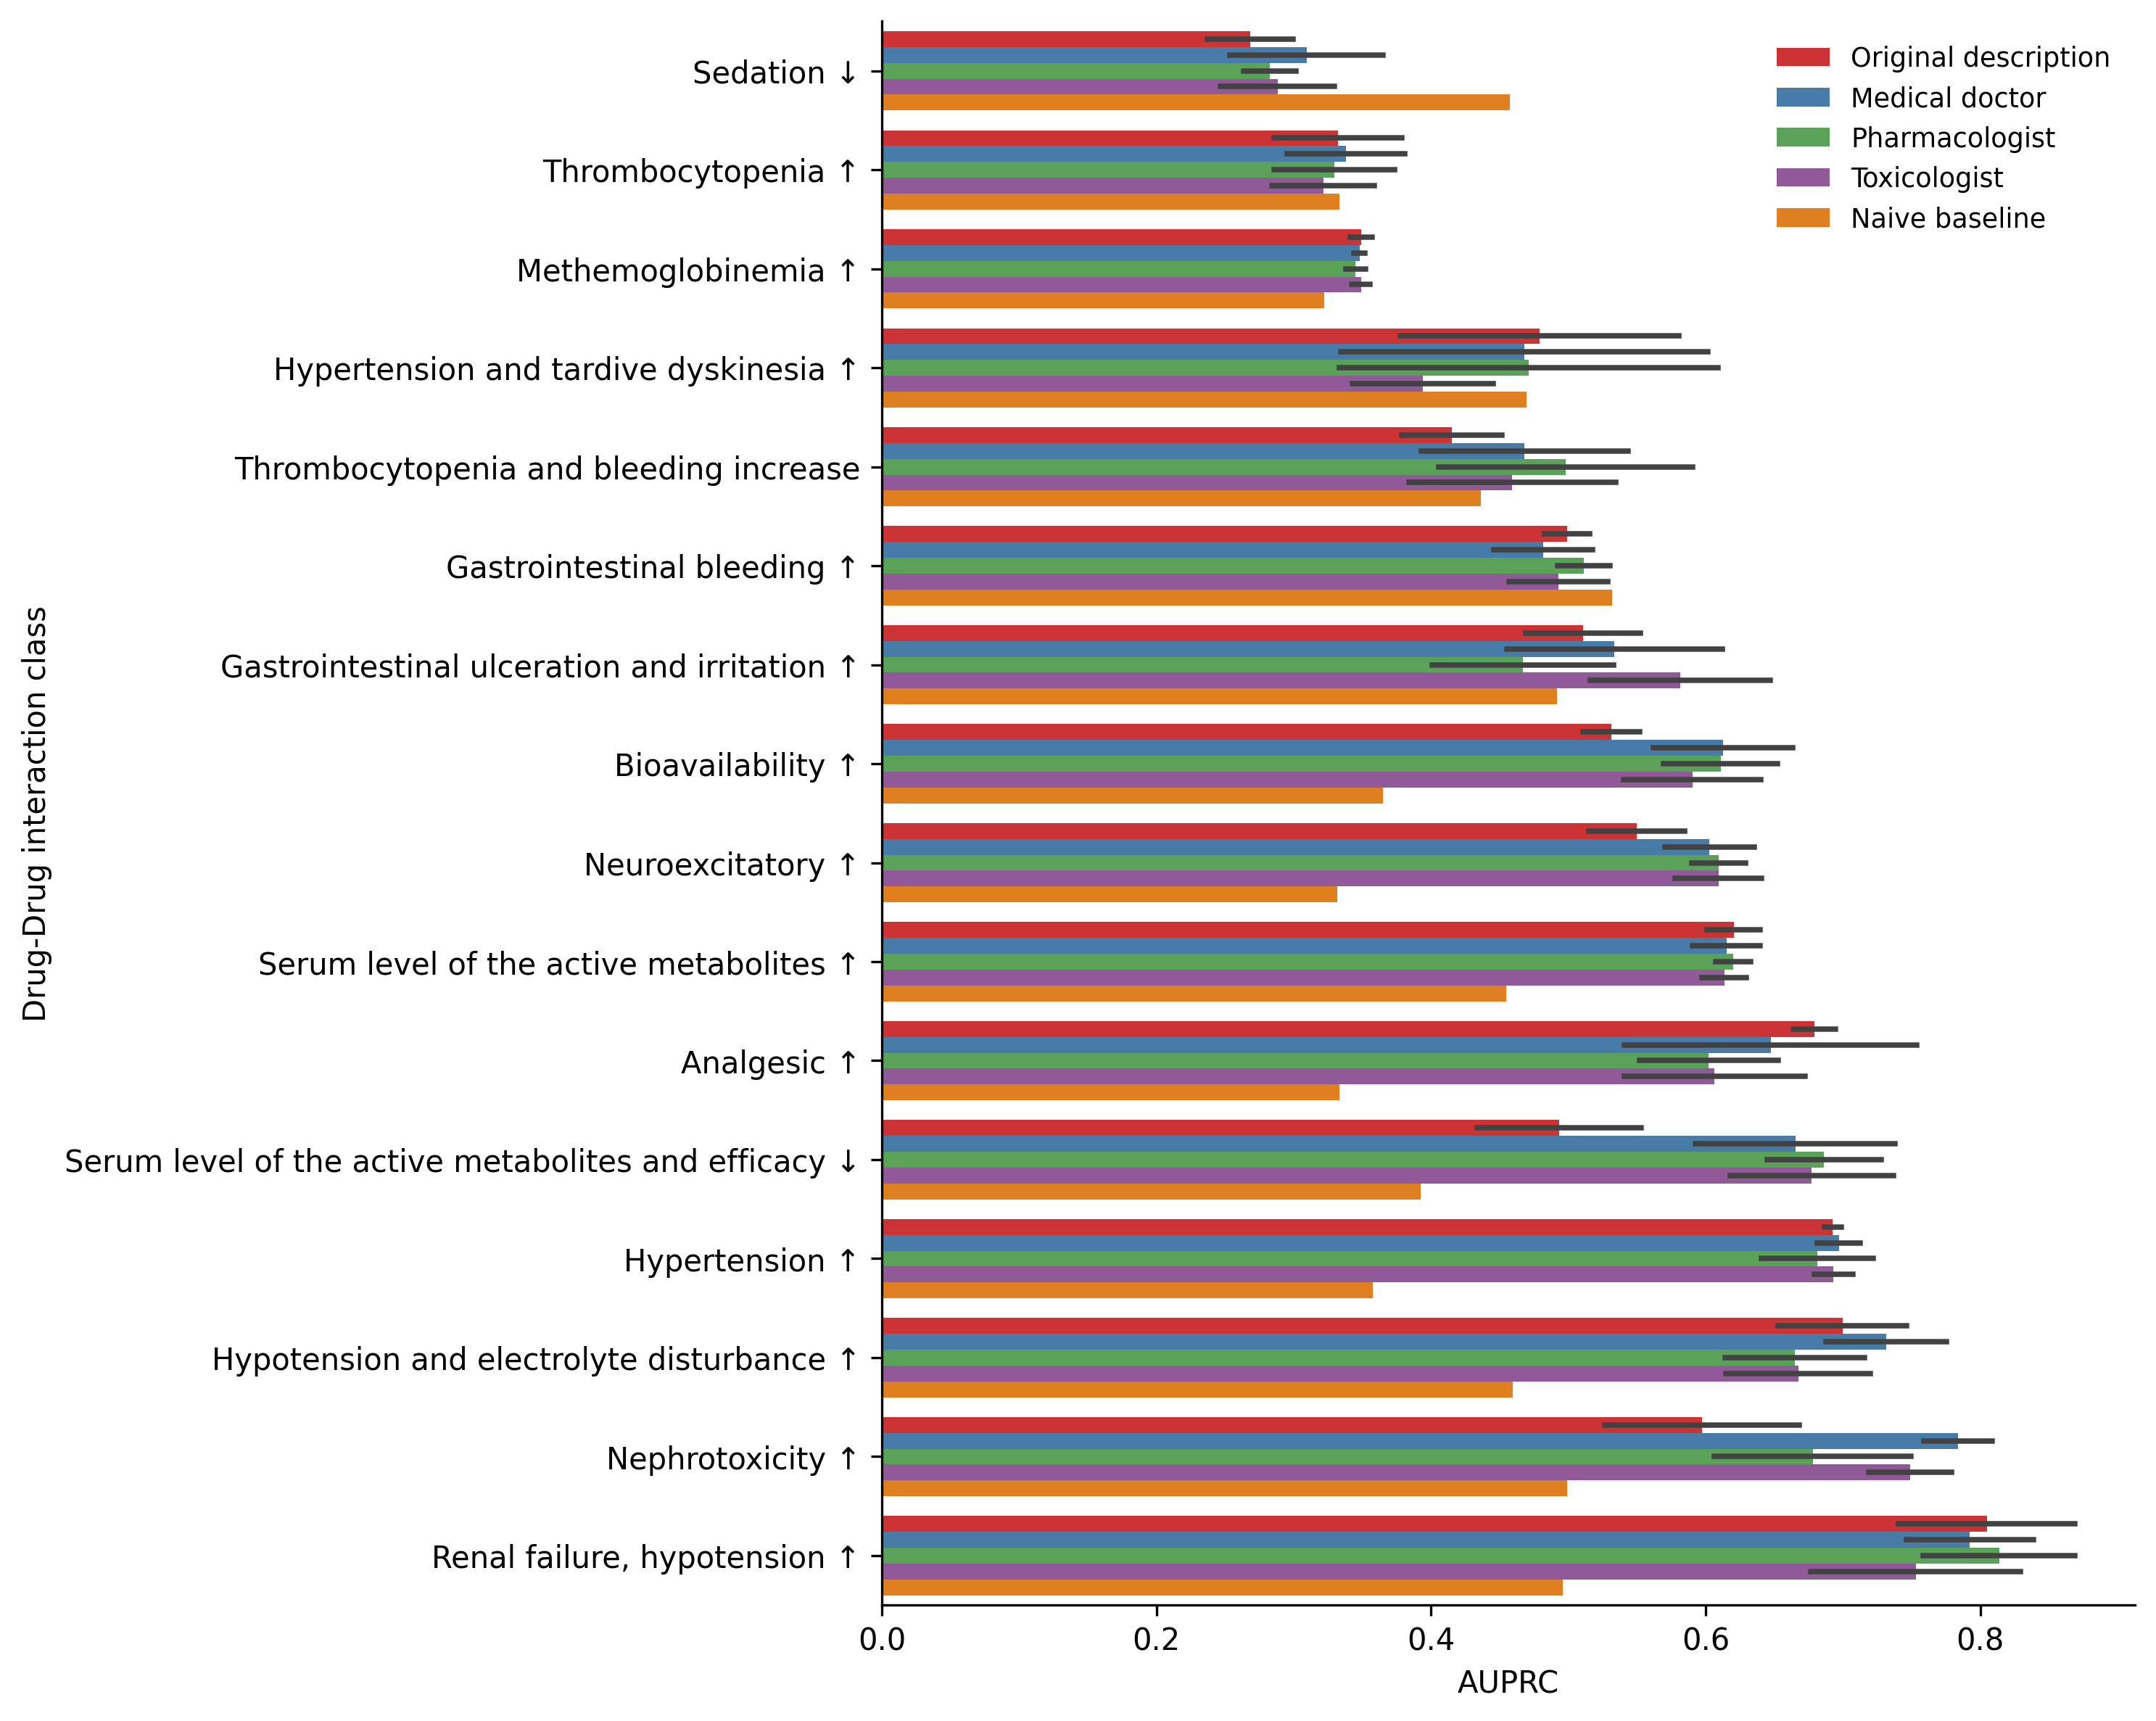

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=300)

result = df_2.groupby(["Drug-Drug interaction class"])['AUPRC'].aggregate(np.mean).reset_index().sort_values('AUPRC')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
g = sns.barplot(
    data=df_2,
    errorbar="sd",
    x="AUPRC", y="Drug-Drug interaction class", hue="label", palette="Set1", order=result['Drug-Drug interaction class'])
sns.despine()
sns.axes_style()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

plt.savefig('performance_paraphrased_rep_sns.pdf')

In [ ]:
# for i in range(14):
#     plot_stratified(run, i, eval_df, test_metrics_naive['auprc'])

## Concordance with original

In [24]:
eval_df = pd.read_csv(f'../LM_decoder/paraphrased_dataset_new/eval_df.csv')
pos_neg = eval_df['pos_neg'].values
labels = eval_df['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]

In [25]:
#all_bl_scores = np.load('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/DrugBank/split_by_pairs/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean.npy')
#eval_scores_bl = all_bl_scores[eval_df['labels'].values, eval_df['head'].values, eval_df['tail'].values]
#np.save('./paraphrased_dataset_new/bl_scores.npy', eval_scores_bl)

In [26]:
def get_correlation(run, epoch):
    
    eval_scores_bl = np.load('./paraphrased_dataset_new/bl_scores.npy')
    
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    
    base = '/n/data1/hms/dbmi/zitnik/lab/users/vau974/ddi/NovelDDI/LM_decoder/'
    
    all_corrs = []
    all_pvals = []
    
    for i in tqdm(range(10)):
        eval_scores_lm = np.load(base + f'{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        corrs = []
        p_vals = []
        for lab in np.unique(labels):
            msk = labels == lab
            bl_scores = eval_scores_bl[msk]
            lm_scores = eval_scores_lm[msk]
            res = spearmanr(bl_scores, lm_scores)
            corrs.append(res[0])
            p_vals.append(res[1])
        
        all_corrs.append(corrs)
        all_pvals.append(p_vals)
        
    return np.array(all_corrs), np.array(all_pvals)

def plot_stratified_corr(runs, epoch):
    
    all_auprc_repeat = []
    all_pvals_repeat = []
    
    for run in runs:
        all_auprc, all_pvals = get_correlation(run, epoch)
        all_auprc_repeat.append(all_auprc)
        all_pvals_repeat.append(all_pvals)
        
    all_auprc_repeat = np.array(all_auprc_repeat)
    all_pvals_repeat = np.array(all_pvals_repeat)
    
    
    return all_auprc_repeat, all_pvals_repeat
    
    
#     #all_pvals_repeat = all_pvals_repeat <= 0.05
    
#     all_auprc_mean_grouped = [0]*4
#     all_auprc_std_grouped = [0]*4
#     all_pval_grouped = [0]*4

#     def stratify_by_paraphrasing(start, stop):
#         elems = []
#         for i in range(len(runs)):
#             for j in range(start, stop):
#                 elems.append(all_auprc_repeat[i,j])
#         return np.stack(elems)
    
#     desc_0 = stratify_by_paraphrasing(0,1)
#     desc_1 = stratify_by_paraphrasing(1,4)
#     desc_2 = stratify_by_paraphrasing(4,7)
#     desc_3 = stratify_by_paraphrasing(7,10)
    
#     all_auprc_mean_grouped[0] = np.mean(desc_0, axis=0)
#     all_auprc_mean_grouped[1] = np.mean(desc_1, axis=0)
#     all_auprc_mean_grouped[2] = np.mean(desc_2, axis=0)
#     all_auprc_mean_grouped[3] = np.mean(desc_3, axis=0)
    
#     all_auprc_std_grouped[0] = np.std(desc_0, axis=0)
#     all_auprc_std_grouped[1] = np.std(desc_1, axis=0)
#     all_auprc_std_grouped[2] = np.std(desc_2, axis=0)
#     all_auprc_std_grouped[3] = np.std(desc_3, axis=0)
    
#     def is_significant(start, stop):
#         elems = []
#         for i in range(len(runs)):
#             for j in range(start, stop):
#                 elems.append(all_pvals_repeat[i,j])
#         p_vals = np.stack(elems)
#         return (p_vals < 0.05).all(axis=0).astype(int)
        
#     all_pval_grouped[0] = is_significant(0,1)
#     all_pval_grouped[1] = is_significant(1,4)
#     all_pval_grouped[2] = is_significant(4,7)
#     all_pval_grouped[3] = is_significant(7,10)
    
#     all_auprc_mean_grouped = np.array(all_auprc_mean_grouped).transpose()
#     all_auprc_std_grouped = np.array(all_auprc_std_grouped).transpose()
#     all_pval_grouped = np.array(all_pval_grouped).transpose().astype(int)
    
#     import matplotlib.pyplot as plt
#     plt.rcParams.update({'font.size': 9})

#     groups = ['Original description', 'Medical doctor', 'Pharmacologist', 'Toxicologist']
#     colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

#     fig, ax = plt.subplots(figsize=(10, 10))

#     # Setting the positions and width for the bars
#     bar_width = 0.2
#     positions = np.arange(len(unique_labels_desc))

#     for i, group in enumerate(groups):
#         # Calculating the position for each group
#         group_positions = positions - (1.5 - i) * bar_width

#         # Plotting the bar for each group
        
#         mn = all_pval_grouped[:, i]*all_auprc_mean_grouped[:, i]
#         sd = all_pval_grouped[:, i]*all_auprc_std_grouped[:, i]
        
#         mn[mn<0.0005] = 0 
#         sd[sd<0.0005] = 0 
        
#         ax.barh(group_positions, mn, bar_width, label=group, xerr=sd, color = colors[i],
#                 edgecolor = "black")


#     ax.set_yticks(positions)
#     ax.set_yticklabels(unique_labels_desc)
#     ax.set_xlabel('Spearman correlation', fontweight='bold')
#     ax.set_ylabel('Drug-Drug interaction class', fontweight='bold')
#     #ax.set_title('Concordance between LM and bilinear by input description type', fontsize = 9)
#     ax.legend(frameon=False, loc='best')
    
#     ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
#     ax.set_axisbelow(True)

#     plt.tight_layout()
#     plt.savefig(f'{"_".join(runs)}_LM_concordance_epoch_{epoch}_cor.pdf')
#     plt.show()
    
#     return all_pvals_repeat

In [27]:
all_corrs_repeat, all_pvals_repeat = plot_stratified_corr(runs, epoch)

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


In [28]:
dfs = []
for i in range(3):
    
    label = ['Original description']*16 + ['Medical doctor']*48 + ['Pharmacologist']*48 + ['Toxicologist']*48
    
    dfs.append(pd.DataFrame({'Rank correlation': all_corrs_repeat[i,:,:].reshape(160),
                             'p-value': all_pvals_repeat[i,:,:].reshape(160),
                             'Drug-Drug interaction class': np.concatenate([new_desc]*10),
                             'label': label}))

In [29]:
df_3 = pd.concat(dfs)
df_3.to_csv('./plot_5c.csv')

In [32]:
def filter_groups(group):
    return group['p-value'].le(0.05).all()

df_3 = df_3.groupby(['Drug-Drug interaction class', 'label']).filter(filter_groups)

#df_3 = df_3[df_3['p-value'] <= 0.05]

In [ ]:
def should_delete_group(group):
    return group[group['p-value'] > 0.05].shape[0] >= 6
groups_to_delete = df_3.groupby(['Drug-Drug interaction class', 'label']).filter(should_delete_group)
indices_to_delete = groups_to_delete.index
df_3 = df_3.drop(indices_to_delete)

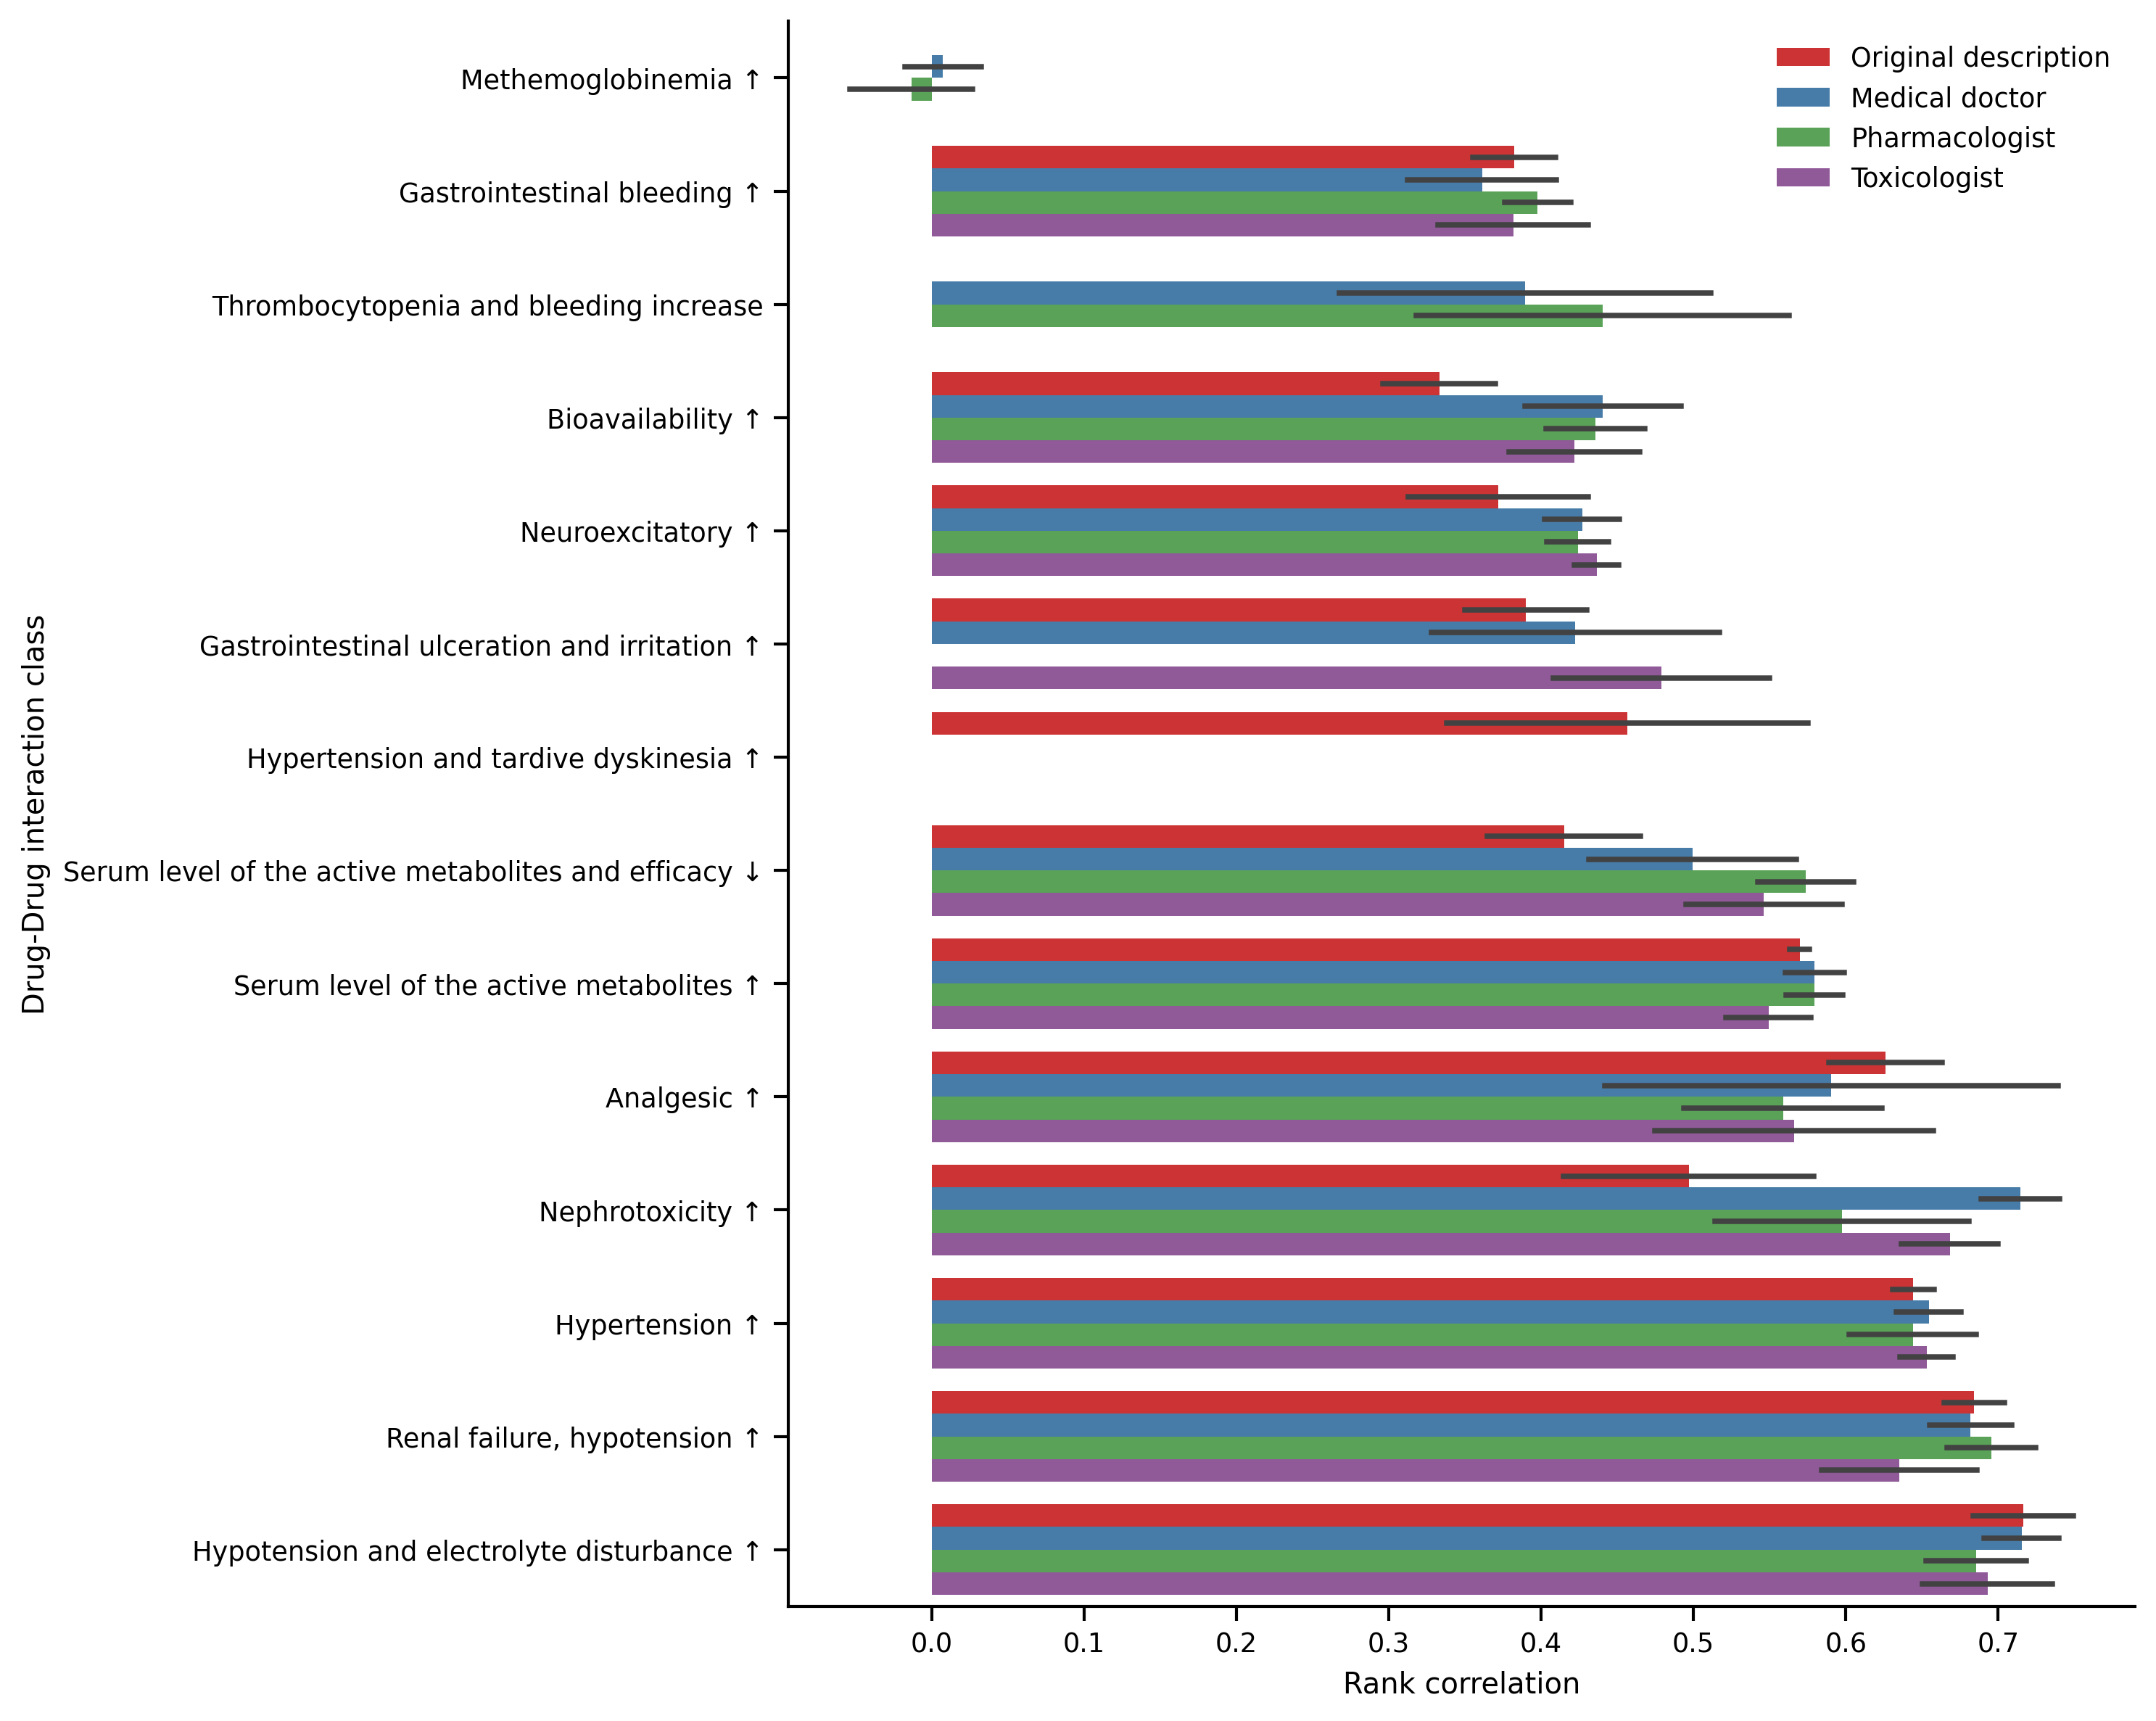

In [40]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=300)

result = df_3.groupby(["Drug-Drug interaction class"])['Rank correlation'].aggregate(np.mean).reset_index().sort_values('Rank correlation')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
g = sns.barplot(
    data=df_3,
    errorbar="sd",
    x="Rank correlation", y="Drug-Drug interaction class", hue="label", palette="Set1", order=result['Drug-Drug interaction class'])
sns.despine()
sns.axes_style()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

plt.savefig('concordance_paraphrased_rep_sns.pdf')

## Reverse DDI direction

In [ ]:
pos = np.load('wandering-cosmos-95/pos_only_raw_scores.npy')
neg = np.load('wandering-cosmos-95/neg_only_raw_scores.npy')
pos_rev = np.load('wandering-cosmos-95/pos_rev_only_raw_scores.npy')

def sig(x):
    return 1/(1 + np.exp(-x))

In [ ]:
sig(pos_rev).std()

In [ ]:
sig(pos).std()

In [ ]:
sig(neg).std()

In [ ]:
array = np.random.rand(30, 16)*0.006

# Compute the result
result = (array < 0.05).all(axis=0).astype(int)


In [ ]:
result